In [ ]:
!pip install triton
!pip install torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 68.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 45.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 30.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 93.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
import torch

import triton
import triton.language as tl

from typing import List, Tuple

In [ ]:
@triton.jit
def forward_kernel(input_ptr, input_low_ptr, input_range_ptr, output_ptr, levels: int, n_elements:int, BLOCK_SIZE: tl.constexpr):
    pid = tl.program_id(axis=0)
    block_start = pid * BLOCK_SIZE
    offsets = block_start + tl.arange(0, BLOCK_SIZE)
    mask = offsets < n_elements

    input_ = tl.load(input_ptr + offsets, mask=mask)
    input_low = tl.load(input_low_ptr + offsets, mask=mask)
    input_range = tl.load(input_range_ptr + offsets, mask=mask)

    scale = (levels - 1) / input_range
    zero_point = -1 * input_low * scale

    input_max = input_low + input_range
    output = tl.clamp(input_, input_low, input_max)
    output -= input_low
    output *= scale
    output -= zero_point
    output = output / scale
    tl.store(output_ptr + offsets, output, mask=mask)


def forward_triton(
    input_: torch.Tensor, input_low: torch.Tensor, input_range: torch.Tensor, levels: int
) -> torch.Tensor:
    output = torch.empty_like(input_)
    n_elements = output.numel()
    BLOCK_SIZE = n_elements
    grid = lambda meta: (triton.cdiv(n_elements, meta['BLOCK_SIZE']), )
    forward_kernel[grid](input_, input_low, input_range, output, levels, n_elements, BLOCK_SIZE=1024)
    return output


def forward(
    input_: torch.Tensor, input_low: torch.Tensor, input_range: torch.Tensor, levels: int
) -> torch.Tensor:
    scale = (levels - 1) / input_range
    output = input_.clip(min=input_low, max=input_low + input_range)
    zero_point = (-input_low * scale)
    output -= input_low
    output *= scale
    output -= zero_point
    output = output / scale
    return output


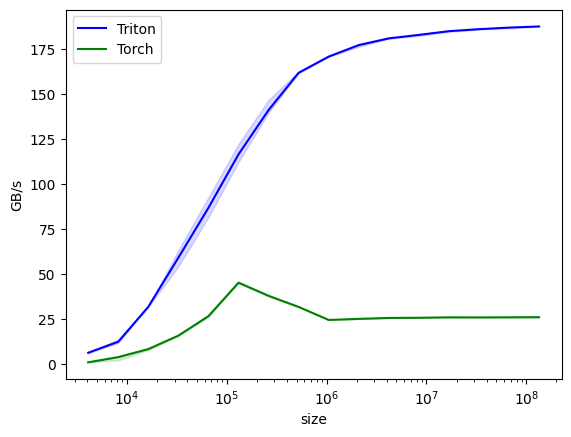

vector-add-performance:
           size      Triton      Torch
0        4096.0    6.508474   1.200000
1        8192.0   12.590164   4.079681
2       16384.0   31.999999   8.545202
3       32768.0   59.219275  15.999999
4       65536.0   86.840989  26.800436
5      131072.0  116.473930  45.322269
6      262144.0  141.038735  38.072810
7      524288.0  161.684218  31.916881
8     1048576.0  170.666661  24.692520
9     2097152.0  177.044581  25.283950
10    4194304.0  180.768180  25.786770
11    8388608.0  182.715884  25.896733
12   16777216.0  184.781963  26.126007
13   33554432.0  185.886132  26.086035
14   67108864.0  186.753815  26.149680
15  134217728.0  187.391426  26.217827


In [ ]:
# https://triton-lang.org/main/getting-started/tutorials/01-vector-add.html

@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['size'],
        x_vals=[2**i for i in range(12, 28, 1)],
        x_log=True,
        line_arg='provider',
        line_vals=['triton', 'torch'],
        line_names=['Triton', 'Torch'],
        styles=[('blue', '-'), ('green', '-')],
        ylabel='GB/s',
        plot_name='vector-add-performance',
        args={},
    ))
def benchmark(size, provider):
    input = torch.rand(size, device='cuda', dtype=torch.float32)
    input_low = torch.rand(size, device='cuda', dtype=torch.float32)
    input_range = torch.rand(size, device='cuda', dtype=torch.float32)
    levels = 10
    quantiles = [0.5, 0.2, 0.8]
    if provider == 'torch':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: forward(input, input_low, input_range, levels), quantiles=quantiles)
    if provider == 'triton':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: forward_triton(input, input_low, input_range, levels), quantiles=quantiles)
    gbps = lambda ms: 3 * input.numel() * input.element_size() * 1e-9 / (ms * 1e-3)
    return gbps(ms), gbps(max_ms), gbps(min_ms)


benchmark.run(print_data=True, show_plots=True)


In [ ]:
def fp32_accum_wrapper(func):
    def wrapper(tensor_to_sum, ret_tensor):
        half = tensor_to_sum.dtype == np.float16
        if half:
            tensor_to_sum = tensor_to_sum.astype(np.float32)
        retval = func(tensor_to_sum, ret_tensor)
        if half:
            retval = retval.astype(np.float16)
        return retval

    return wrapper


@fp32_accum_wrapper
def sum_like(tensor_to_sum, ref_tensor):
    """Warning: may modify tensor_to_sum"""
    if ref_tensor.size == 1:
        return tensor_to_sum.sum()

    for dim, size in enumerate(ref_tensor.shape):
        if size == 1:
            if isinstance(tensor_to_sum, np.ndarray):
                tensor_to_sum = tensor_to_sum.sum(dim, keepdims=True)
            else:
                tensor_to_sum = tensor_to_sum.sum(dim, keepdim=True)
    return tensor_to_sum

In [ ]:
@triton.jit
def backward_kernel(
    grad_output_ptr: torch.Tensor,
    input_ptr: torch.Tensor,
    input_low_ptr: torch.Tensor,
    input_range_ptr: torch.Tensor,
    output_ptr: torch.Tensor,
    grad_input_ptr: torch.Tensor,
    grad_low_ptr: torch.Tensor,
    grad_range_ptr: torch.Tensor,
    mask_lo_ptr: torch.Tensor,
    mask_hi_ptr: torch.Tensor,
    range_sign_ptr: torch.Tensor,
    level_low: int,
    level_high: int,
    n_elements: int,
    is_asymmetric,
    BLOCK_SIZE: tl.constexpr
) -> List[torch.Tensor]:
    # is_asymmetric is unused, present only to correspond to the CPU signature of calling "backward"
    # sum_like not implemented yet



    pid = tl.program_id(axis=0)
    block_start = pid * BLOCK_SIZE
    offsets = block_start + tl.arange(0, BLOCK_SIZE)
    mask = offsets < n_elements

    grad_output = tl.load(grad_output_ptr + offsets, mask=mask)
    input_ = tl.load(input_ptr + offsets, mask=mask)
    input_low = tl.load(input_low_ptr + offsets, mask=mask)
    input_range = tl.load(input_range_ptr + offsets, mask=mask)
    output = tl.load(output_ptr + offsets, mask=mask)

    mask_lo = tl.load(mask_lo_ptr + offsets, mask=mask)
    mask_hi = tl.load(mask_hi_ptr + offsets, mask=mask)
    range_sign = tl.load(range_sign_ptr + offsets, mask=mask)

    mask_in = 1 - mask_hi - mask_lo

    err = (output - input_) / (input_range * range_sign)
    grad_range = grad_output * (err * mask_in + range_sign * (level_low / level_high) * mask_lo + mask_hi)

    grad_input = grad_output * mask_in

    grad_low = grad_output * (mask_hi + mask_lo)


    tl.store(grad_input_ptr + offsets, grad_input, mask=mask)
    tl.store(grad_low_ptr + offsets, grad_low, mask=mask)
    tl.store(grad_range_ptr + offsets, grad_range, mask=mask)


def backward_triton(
    grad_output: torch.Tensor,
    input_: torch.Tensor,
    input_low: torch.Tensor,
    input_range: torch.Tensor,
    output: torch.Tensor,
    level_low: int,
    level_high: int,
    is_asymmetric: bool = False,
) -> List[torch.Tensor]:

    mask_hi = input_ > (input_low + input_range)
    mask_lo = input_ < input_low
    mask_hi = mask_hi.type(input_.dtype)
    mask_lo = mask_lo.type(input_.dtype)
    range_sign = torch.sign(input_range)

    grad_input = torch.empty_like(input_)
    grad_low = torch.empty_like(input_)
    grad_range = torch.empty_like(input_)

    n_elements = input_.numel()
    # how to pass this tuple to kernel, can use pointer and n_dims maybe
    # input_shape = input_.shape
    BLOCK_SIZE = n_elements
    grid = lambda meta: (triton.cdiv(n_elements, meta['BLOCK_SIZE']), )
    backward_kernel[grid](grad_output, input_, input_low, input_range, output, grad_input, grad_low, grad_range, mask_lo, mask_hi, range_sign, level_low, level_high, n_elements, is_asymmetric=False, BLOCK_SIZE=1024)
    return [grad_input, grad_low, grad_range]

def backward(
    grad_output: torch.Tensor,
    input_: torch.Tensor,
    input_low: torch.Tensor,
    input_range: torch.Tensor,
    output: torch.Tensor,
    level_low: int,
    level_high: int,
    is_asymmetric: bool = False,
) -> List[torch.Tensor]:
    # is_asymmetric is unused, present only to correspond to the CPU signature of calling "backward"
    mask_hi = input_ > (input_low + input_range)
    mask_hi = mask_hi.type(input_.dtype)
    mask_lo = input_ < input_low
    mask_lo = mask_lo.type(input_.dtype)

    mask_in = 1 - mask_hi - mask_lo
    range_sign = torch.sign(input_range)
    err = (output - input_) * torch.reciprocal(input_range * range_sign)
    grad_range = grad_output * (err * mask_in + range_sign * (level_low / level_high) * mask_lo + mask_hi)
    grad_range = sum_like(grad_range, input_range)

    grad_input = grad_output * mask_in

    grad_low = grad_output * (mask_hi + mask_lo)
    grad_low = sum_like(grad_low, input_low)
    return [grad_input, grad_low, grad_range]


In [ ]:
torch.manual_seed(1000)
size = 5000
grad_output = torch.rand(size, device='cuda')
input_ = torch.rand(size, device='cuda')
input_low = torch.rand(size, device='cuda')
input_range = torch.rand(size, device='cuda')
output = torch.rand(size, device='cuda')
level_low = 10
level_high = 50
is_asymmetric = False

grad_input_torch, grad_low_torch, grad_range_torch = backward(grad_output, input_, input_low, input_range, output, level_low, level_high, is_asymmetric)
grad_input_triton, grad_low_triton, grad_range_triton = backward_triton(grad_output, input_, input_low, input_range, output, level_low, level_high, is_asymmetric)
print(f'the maximum difference between torch and triton is '
      f'{torch.max(torch.abs(grad_input_torch - grad_range_triton)), torch.max(torch.abs(grad_low_torch - grad_low_triton)), torch.max(torch.abs(grad_range_torch - grad_range_triton))}')
print(torch.allclose(grad_input_torch, grad_range_triton), torch.allclose(grad_low_torch, grad_low_triton), torch.allclose(grad_range_torch, grad_range_triton))

the maximum difference between torch and triton is (tensor(13.4639, device='cuda:0'), tensor(0., device='cuda:0'), tensor(4.7684e-07, device='cuda:0'))
False True True


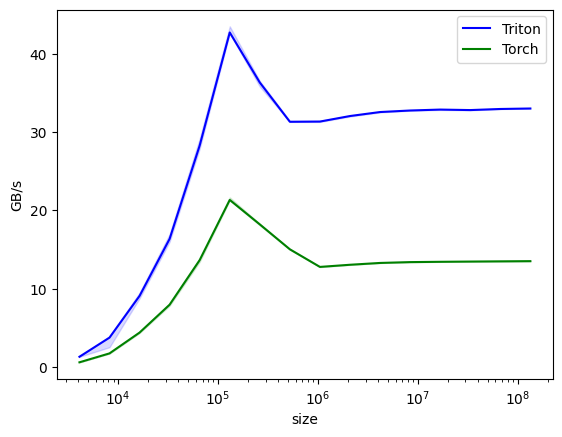

vector-add-performance:
           size     Triton      Torch
0        4096.0   1.268373   0.557937
1        8192.0   3.719128   1.700055
2       16384.0   9.061947   4.363636
3       32768.0  16.362183   7.937984
4       65536.0  28.313365  13.649542
5      131072.0  42.778067  21.342596
6      262144.0  36.368478  18.211189
7      524288.0  31.346940  15.022005
8     1048576.0  31.374452  12.769241
9     2097152.0  32.083550  13.045019
10    4194304.0  32.594165  13.277203
11    8388608.0  32.790886  13.384368
12   16777216.0  32.909408  13.423290
13   33554432.0  32.845752  13.453703
14   67108864.0  32.985153  13.481379
15  134217728.0  33.047561  13.506892


In [ ]:
# https://triton-lang.org/main/getting-started/tutorials/01-vector-add.html

@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['size'],
        x_vals=[2**i for i in range(12, 28, 1)],
        x_log=True,
        line_arg='provider',
        line_vals=['triton', 'torch'],
        line_names=['Triton', 'Torch'],
        styles=[('blue', '-'), ('green', '-')],
        ylabel='GB/s',
        plot_name='vector-add-performance',
        args={},
    ))
def benchmark(size, provider):
    grad_output = torch.rand(size, device='cuda', dtype=torch.float32)
    input_ = torch.rand(size, device='cuda', dtype=torch.float32)
    input_low = torch.rand(size, device='cuda', dtype=torch.float32)
    input_range = torch.rand(size, device='cuda', dtype=torch.float32)
    output = torch.rand(size, device='cuda', dtype=torch.float32)
    level_low = 10
    level_high = 50
    is_asymmetric = False
    input = torch.rand(size, device='cuda', dtype=torch.float32)
    input_low = torch.rand(size, device='cuda', dtype=torch.float32)
    input_range = torch.rand(size, device='cuda', dtype=torch.float32)
    levels = 10
    quantiles = [0.5, 0.2, 0.8]
    if provider == 'torch':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: backward(grad_output, input_, input_low, input_range, output, level_low, level_high, is_asymmetric), quantiles=quantiles)
    if provider == 'triton':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: backward_triton(grad_output, input_, input_low, input_range, output, level_low, level_high, is_asymmetric), quantiles=quantiles)
    gbps = lambda ms: 3 * input.numel() * input.element_size() * 1e-9 / (ms * 1e-3)
    return gbps(ms), gbps(max_ms), gbps(min_ms)


benchmark.run(print_data=True, show_plots=True)
